# Statistical inference of stock returns with linear regression

## Imports & Settings

In [1]:
from pathlib import Path
from time import time
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import spearmanr, norm

from sklearn.metrics import mean_squared_error, make_scorer, roc_auc_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold

from empyrical import max_drawdown, sortino_ratio
from custom_scoring import spearman_corr

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
idx = pd.IndexSlice

## Load Data

In [3]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

### Select Investment Universe

In [4]:
data = data[data.dollar_vol_rank<100]

In [5]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109663 entries, ('AAL', Timestamp('2013-07-24 00:00:00')) to ('ZTS', Timestamp('2014-12-09 00:00:00'))
Data columns (total 64 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109663 non-null  float64
 1   dollar_vol             109663 non-null  float64
 2   dollar_vol_rank        109663 non-null  float64
 3   rsi                    109663 non-null  float64
 4   bb_high                109663 non-null  float64
 5   bb_low                 109663 non-null  float64
 6   atr                    109663 non-null  float64
 7   macd                   109663 non-null  float64
 8   return_1d              109663 non-null  float64
 9   return_5d              109663 non-null  float64
 10  return_10d             109663 non-null  float64
 11  return_21d             109663 non-null  float64
 12  return_42d             109663 non-null  float64
 13  return_63d    

### Create Model Data

In [6]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

## Explore Data

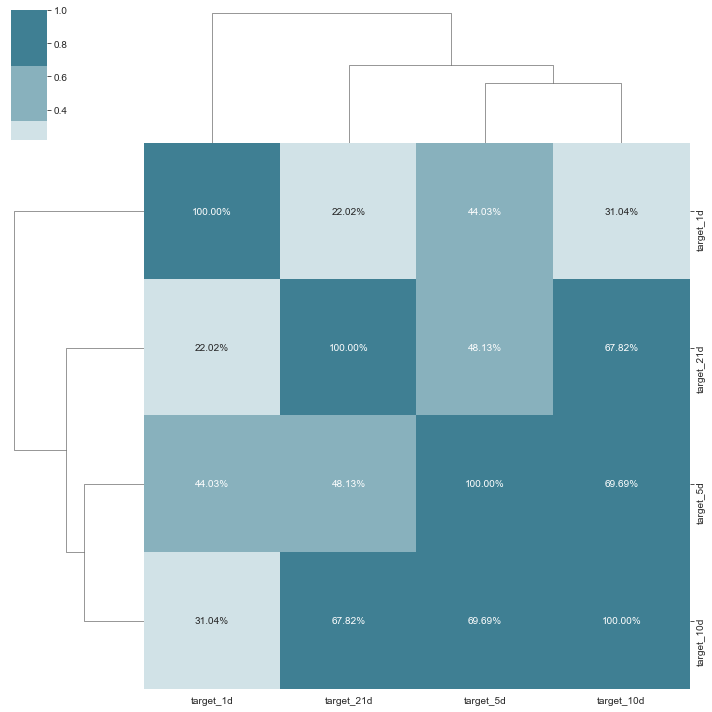

In [9]:
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%');

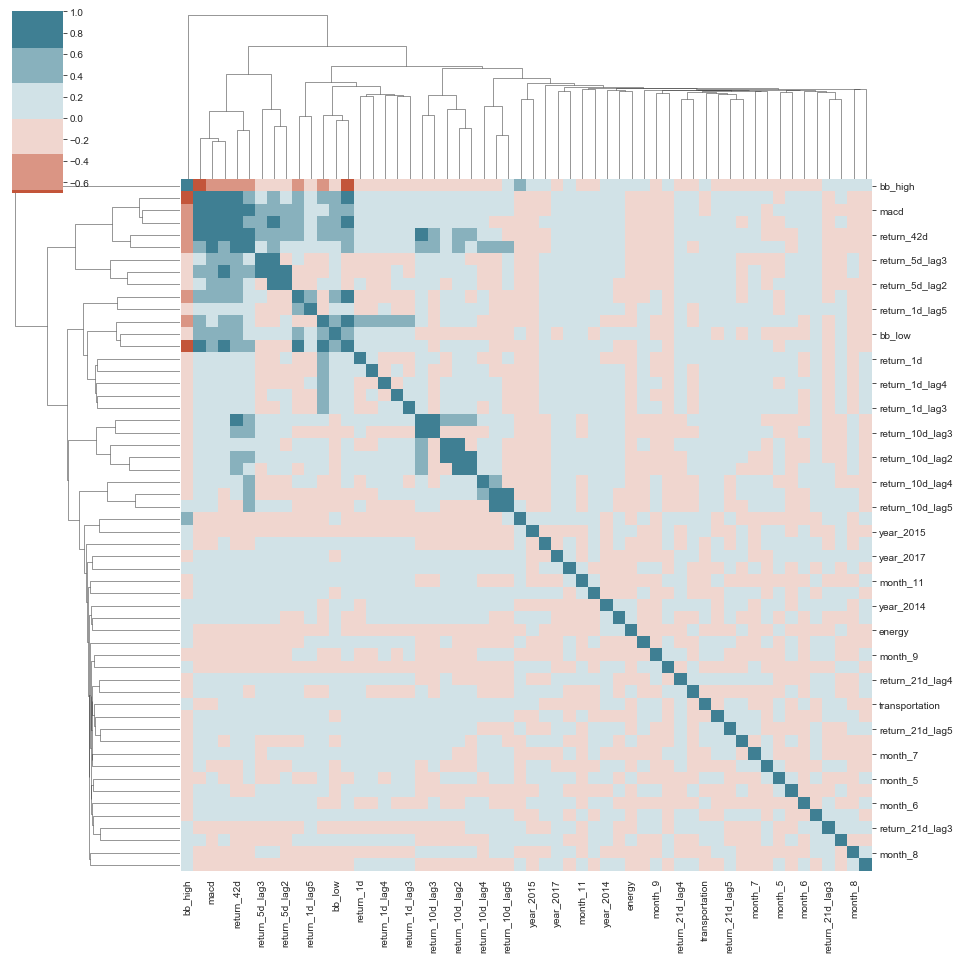

In [10]:
sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);
plt.gcf().set_size_inches((14, 14))

In [11]:
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False)

In [12]:
corr_mat.head().append(corr_mat.tail())

,var1,var2,corr
569,return_63d,return_42d,0.834447
514,return_42d,return_63d,0.834447
4,rsi,macd,0.818374
224,macd,rsi,0.818374
452,return_21d,macd,0.803368
449,return_21d,bb_high,-0.625328
63,bb_high,return_10d,-0.693075
393,return_10d,bb_high,-0.693075
56,bb_high,rsi,-0.699712
1,rsi,bb_high,-0.699712


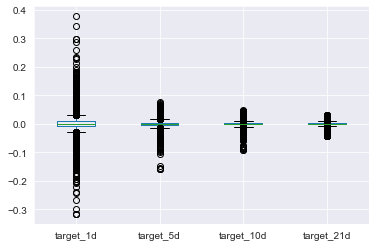

In [13]:
y.boxplot();

## Linear Regression for Statistical Inference: OLS with statsmodels

### Ticker-wise standardization

`statsmodels` warns of high design matrix condition numbers. This can arise when the variables are not standardized and the Eigenvalues differ due to scaling. The following step avoids this warning.

In [7]:
sectors = X.iloc[:, -10:]
X = (X.drop(sectors.columns, axis=1)
     .groupby(level='ticker')
     .transform(lambda x: (x - x.mean()) / x.std())
    .join(sectors)
    .fillna(0))

### 1-Day Returns

In [15]:
target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     19.73
Date:                Fri, 14 Feb 2020   Prob (F-statistic):          1.47e-193
Time:                        11:13:53   Log-Likelihood:             2.9067e+05
No. Observations:              109663   AIC:                        -5.812e+05
Df Residuals:                  109606   BIC:                        -5.807e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2.717e-

### 5-Day Returns

In [8]:
target = 'target_5d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_5d   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     66.12
Date:                Tue, 07 Apr 2020   Prob (F-statistic):               0.00
Time:                        13:08:32   Log-Likelihood:             3.8129e+05
No. Observations:              109663   AIC:                        -7.625e+05
Df Residuals:                  109606   BIC:                        -7.619e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

#### Obtain the residuals

In [17]:
preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

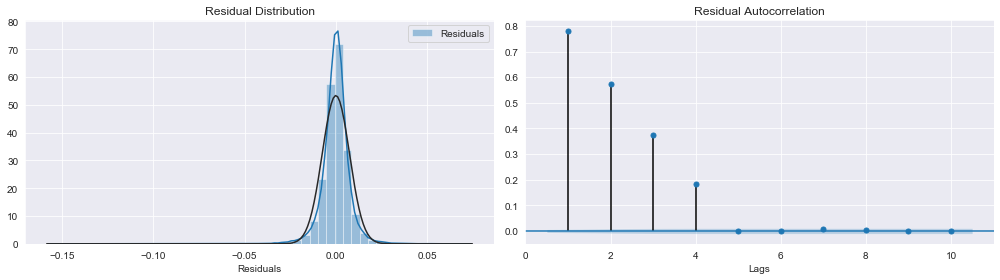

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
fig.tight_layout()
fig.savefig('figures/ols_residuals', dpi=300);

In [ ]:
graphics.influence_plot(trained_model, criterion="cooks")

### 10-Day Returns

In [20]:
target = 'target_10d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_10d   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     92.88
Date:                Fri, 14 Feb 2020   Prob (F-statistic):               0.00
Time:                        11:13:56   Log-Likelihood:             4.2171e+05
No. Observations:              109663   AIC:                        -8.433e+05
Df Residuals:                  109606   BIC:                        -8.428e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### Monthly Returns

In [21]:
target = 'target_21d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_21d   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     136.4
Date:                Fri, 14 Feb 2020   Prob (F-statistic):               0.00
Time:                        11:13:57   Log-Likelihood:             4.6522e+05
No. Observations:              109663   AIC:                        -9.303e+05
Df Residuals:                  109606   BIC:                        -9.298e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00